In [50]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 24.9 MB/s eta 0:00:00


In [53]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.2 MB/s eta 0:00:00


In [55]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 15.9 MB/s eta 0:00:00


In [56]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 10.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=d1933879df66762774e7982ea8cc60665e6a904e7cdb7bc47e240a65b60b0cd2
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [4]:
# train.csv upload

from google.colab import files
train_uploaded = files.upload()

Saving train.csv to train.csv


In [3]:
# test.csv upload

test_uploaded = files.upload()

Saving test.csv to test.csv


In [6]:
TRAIN_FILENAME = next(iter(train_uploaded))
TEST_FILENAME = next(iter(test_uploaded))

In [13]:
TRAIN_PATH = "/content/" + TRAIN_FILENAME
TEST_PATH = "/content/" + TEST_FILENAME

In [120]:
# import the necessary libraries

import os
import math
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

import optuna
import shap
import category_encoders as ce

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

import lifelines
from lifelines import CoxPHFitter

import warnings
warnings.filterwarnings('ignore')

In [18]:
def load_data(train_path, test_path):
    df_train = pd.read_csv(train_path)
    df_test  = pd.read_csv(test_path)

    # Standard column names
    df_train = df_train.rename(columns={
        'Customer ID': 'CustomerID',
        'Transaction Date': 'TransactionDate',
        'Product Category': 'ProductCategory',
        'Purchase Amount': 'PurchaseAmount'
    })
    df_test = df_test.rename(columns={
        'Customer ID': 'CustomerID',
        'Transaction Date': 'TransactionDate',
        'Product Category': 'ProductCategory',
        'Purchase Amount': 'PurchaseAmount'
    })

    # Convert date to datetime
    df_train['TransactionDate'] = pd.to_datetime(df_train['TransactionDate'])
    df_test['TransactionDate']  = pd.to_datetime(df_test['TransactionDate'])

    # Sort
    df_train = df_train.sort_values(['CustomerID','TransactionDate']).reset_index(drop=True)
    df_test  = df_test.sort_values(['CustomerID','TransactionDate']).reset_index(drop=True)

    return df_train, df_test

In [19]:
df_train, df_test = load_data(TRAIN_PATH, TEST_PATH)

In [20]:
print(df_train.head(3))
print(df_train.dtypes)
print(f"Train rows: {len(df_train):,} | Test rows: {len(df_test):,}")

   CustomerID TransactionDate     ProductCategory  PurchaseAmount
0         636      2021-07-25  Non Finished Goods          469.08
1         636      2021-07-25       Personal Care         8413.86
2         636      2021-11-28       Personal Care         8801.68
CustomerID                  int64
TransactionDate    datetime64[ns]
ProductCategory            object
PurchaseAmount            float64
dtype: object
Train rows: 41,984 | Test rows: 889


In [21]:
def add_basic_customer_ordering(df):
    df = df.sort_values(['CustomerID','TransactionDate']).copy()
    df['TxnIdx'] = df.groupby('CustomerID').cumcount()
    df['TxnCount'] = df.groupby('CustomerID')['CustomerID'].transform('count')
    return df

In [24]:
def add_gap_features(df):
    df['PrevDate'] = df.groupby('CustomerID')['TransactionDate'].shift(1)
    df['NextDate'] = df.groupby('CustomerID')['TransactionDate'].shift(-1)
    df['DaysSincePrev'] = (df['TransactionDate'] - df['PrevDate']).dt.days
    df['DaysToNext']    = (df['NextDate'] - df['TransactionDate']).dt.days
    for k in [1,2,3,4,5]:
        df[f'GapLag{k}'] = df.groupby('CustomerID')['DaysSincePrev'].shift(k)
    for w in [2,3,5,10]:
        grp = df.groupby('CustomerID')['DaysSincePrev']
        df[f'GapRollMean_w{w}'] = grp.transform(lambda s: s.rolling(w, min_periods=1).mean())
        df[f'GapRollStd_w{w}']  = grp.transform(lambda s: s.rolling(w, min_periods=2).std())
        df[f'GapRollMed_w{w}']  = grp.transform(lambda s: s.rolling(w, min_periods=1).median())
    agg = df.groupby('CustomerID')['DaysSincePrev'].agg(['mean','median','std','min','max']).add_prefix('CustGap_')
    df = df.merge(agg, left_on='CustomerID', right_index=True, how='left')
    return df

In [23]:
print(df_train.head(3))

   CustomerID TransactionDate     ProductCategory  PurchaseAmount
0         636      2021-07-25  Non Finished Goods          469.08
1         636      2021-07-25       Personal Care         8413.86
2         636      2021-11-28       Personal Care         8801.68


In [25]:
def add_amount_features(df):
    for k in [1,2,3]:
        df[f'AmtLag{k}'] = df.groupby('CustomerID')['PurchaseAmount'].shift(k)
    for w in [2,3,5,10]:
        grp = df.groupby('CustomerID')['PurchaseAmount']
        df[f'AmtRollMean_w{w}'] = grp.transform(lambda s: s.rolling(w, min_periods=1).mean())
        df[f'AmtRollStd_w{w}']  = grp.transform(lambda s: s.rolling(w, min_periods=2).std())
        df[f'AmtRollMed_w{w}']  = grp.transform(lambda s: s.rolling(w, min_periods=1).median())
    cust_amt = df.groupby('CustomerID')['PurchaseAmount'].agg(['mean','median','std','sum','max','min']).add_prefix('CustAmt_')
    df = df.merge(cust_amt, left_on='CustomerID', right_index=True, how='left')
    return df

In [26]:
def _entropy(counts):
    total = counts.sum()
    if total <= 0: return 0.0
    p = counts / total
    return float(-(p * np.log(p + 1e-12)).sum())

In [27]:
def add_category_features(df, top_n_onehot=20):
    cust_cat_counts = df.groupby(['CustomerID','ProductCategory']).size().rename('CustCatCount').reset_index()
    df = df.merge(cust_cat_counts, on=['CustomerID','ProductCategory'], how='left')
    tmp = df.groupby(['CustomerID','ProductCategory']).size().rename('cnt').reset_index()
    div = tmp.groupby('CustomerID')['ProductCategory'].nunique().rename('CustCatUnique')
    ent = tmp.groupby('CustomerID')['cnt'].apply(_entropy).rename('CustCatEntropy')
    df = df.merge(div, on='CustomerID', how='left').merge(ent, on='CustomerID', how='left')

    gfreq = df['ProductCategory'].value_counts(normalize=True).to_dict()
    df['CatGlobalFreq'] = df['ProductCategory'].map(gfreq)
    df['CustCatFreq'] = df['CustCatCount'] / df.groupby('CustomerID')['CustCatCount'].transform('sum')
    topN = df['ProductCategory'].value_counts().head(top_n_onehot).index.tolist()
    df['ProductCategory_OH'] = df['ProductCategory'].where(df['ProductCategory'].isin(topN), 'OTHER')
    oh = pd.get_dummies(df['ProductCategory_OH'], prefix='Cat')
    df = pd.concat([df, oh], axis=1)
    return df

In [28]:
def add_time_features(df):
    d = df['TransactionDate']
    df['TXN_Year'] = d.dt.year
    df['TXN_Month'] = d.dt.month
    df['TXN_Day'] = d.dt.day
    df['TXN_DayOfWeek'] = d.dt.dayofweek
    df['TXN_IsWeekend'] = df['TXN_DayOfWeek'].isin([5,6]).astype(int)
    df['TXN_WeekOfYear'] = d.dt.isocalendar().week.astype(int)
    df['TXN_Quarter'] = d.dt.quarter
    return df

In [29]:
def build_features(df):
    df = add_basic_customer_ordering(df)
    df = add_gap_features(df)
    df = add_amount_features(df)
    df = add_category_features(df, top_n_onehot=20)
    df = add_time_features(df)
    return df

In [30]:
df_train = build_features(df_train)
df_test  = build_features(df_test)

In [31]:
df_train_labeled = df_train[~df_train['DaysToNext'].isna()].copy()
print("Train labeled rows:", len(df_train_labeled))

Train labeled rows: 41354


In [32]:
print(df_train.head(3))

   CustomerID TransactionDate     ProductCategory  PurchaseAmount  TxnIdx  \
0         636      2021-07-25  Non Finished Goods          469.08       0   
1         636      2021-07-25       Personal Care         8413.86       1   
2         636      2021-11-28       Personal Care         8801.68       2   

   TxnCount   PrevDate   NextDate  DaysSincePrev  DaysToNext  ...  \
0         4        NaT 2021-07-25            NaN         0.0  ...   
1         4 2021-07-25 2021-11-28            0.0       126.0  ...   
2         4 2021-07-25 2021-11-28          126.0         0.0  ...   

   Cat_Shrink Film  Cat_Specialty Foods - Other  Cat_Unknown  TXN_Year  \
0            False                        False        False      2021   
1            False                        False        False      2021   
2            False                        False        False      2021   

   TXN_Month  TXN_Day  TXN_DayOfWeek  TXN_IsWeekend  TXN_WeekOfYear  \
0          7       25              6          

In [33]:
# Time based split and strong baselines

def time_based_split(df, date_col='TransactionDate', holdout_frac=0.2):
    cutoff = df[date_col].quantile(1 - holdout_frac)
    return df[df[date_col] < cutoff].copy(), df[df[date_col] >= cutoff].copy(), cutoff

In [34]:
train_part, valid_part, cutoff_date = time_based_split(df_train_labeled, 'TransactionDate', 0.2)
print(f"Cutoff={cutoff_date}, train={len(train_part)}, valid={len(valid_part)}")


Cutoff=2024-02-04 00:00:00, train=33016, valid=8338


In [59]:
def evaluate(y_true, y_pred, label):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{label:28s} -> MAE: {mae:.3f} | RMSE: {rmse:.3f}")
    return mae, rmse

In [60]:
last_gap_valid = valid_part['DaysSincePrev'].fillna(valid_part['DaysSincePrev'].median())
cust_mean_gap_valid = valid_part.groupby('CustomerID')['DaysSincePrev'].transform('mean')
cust_mean_gap_valid = cust_mean_gap_valid.fillna(valid_part['DaysSincePrev'].median())
global_median = valid_part['DaysToNext'].median()
global_median_valid = pd.Series(global_median, index=valid_part.index)

_ = evaluate(valid_part['DaysToNext'], last_gap_valid,        "Baseline: last gap")
_ = evaluate(valid_part['DaysToNext'], cust_mean_gap_valid,   "Baseline: customer mean gap")
_ = evaluate(valid_part['DaysToNext'], global_median_valid,   "Baseline: global median gap")

Baseline: last gap           -> MAE: 16.633 | RMSE: 43.688
Baseline: customer mean gap  -> MAE: 11.190 | RMSE: 27.797
Baseline: global median gap  -> MAE: 10.267 | RMSE: 24.725


In [61]:
# Feature selection & imputation

base_num = [
    'DaysSincePrev','TxnIdx','TxnCount',
    'GapLag1','GapLag2','GapLag3','GapLag4','GapLag5',
    'GapRollMean_w2','GapRollStd_w2','GapRollMed_w2',
    'GapRollMean_w3','GapRollStd_w3','GapRollMed_w3',
    'GapRollMean_w5','GapRollStd_w5','GapRollMed_w5',
    'GapRollMean_w10','GapRollStd_w10','GapRollMed_w10',
    'CustGap_mean','CustGap_median','CustGap_std','CustGap_min','CustGap_max',
    'PurchaseAmount','AmtLag1','AmtLag2','AmtLag3',
    'AmtRollMean_w2','AmtRollStd_w2','AmtRollMed_w2',
    'AmtRollMean_w3','AmtRollStd_w3','AmtRollMed_w3',
    'AmtRollMean_w5','AmtRollStd_w5','AmtRollMed_w5',
    'AmtRollMean_w10','AmtRollStd_w10','AmtRollMed_w10',
    'CustAmt_mean','CustAmt_median','CustAmt_std','CustAmt_sum','CustAmt_max','CustAmt_min',
    'CustCatCount','CustCatUnique','CustCatEntropy','CatGlobalFreq','CustCatFreq',
    'TXN_Year','TXN_Month','TXN_Day','TXN_DayOfWeek','TXN_IsWeekend','TXN_WeekOfYear','TXN_Quarter'
]
oh_cols = [c for c in df_train.columns if c.startswith('Cat_')]
feature_cols = base_num + oh_cols

X_train = train_part[feature_cols].copy()
y_train = train_part['DaysToNext'].astype(float).copy()
X_valid = valid_part[feature_cols].copy()
y_valid = valid_part['DaysToNext'].astype(float).copy()

imputer = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=feature_cols, index=X_train.index)
X_valid_imp = pd.DataFrame(imputer.transform(X_valid), columns=feature_cols, index=X_valid.index)

In [63]:
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'boosting_type': trial.suggest_categorical('boosting', ['gbdt','dart']),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 200),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth', -1, 12),
        'verbosity': -1,
        'num_threads': 0
    }

    dtrain = lgb.Dataset(X_train_imp, label=y_train)
    dvalid = lgb.Dataset(X_valid_imp, label=y_valid, reference=dtrain)

    cbs = [
        lgb.early_stopping(stopping_rounds=200),
        lgb.log_evaluation(period=0)
    ]

    try:
        model = lgb.train(
            params,
            dtrain,
            valid_sets=[dtrain, dvalid],
            valid_names=['train','valid'],
            num_boost_round=5000,
            callbacks=cbs
        )
        preds = model.predict(X_valid_imp, num_iteration=model.best_iteration)
    except TypeError:
        model = lgb.LGBMRegressor(
            **{k:v for k,v in params.items() if k not in ['objective','metric','verbosity','num_threads']},
            objective='regression'
        )
        model.fit(
            X_train_imp, y_train,
            eval_set=[(X_valid_imp, y_valid)],
            verbose=False
        )
        preds = model.predict(X_valid_imp)

    return mean_absolute_error(y_valid, preds)

In [67]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40, show_progress_bar=True)

best_params = study.best_trial.params
best_params.update({'objective':'regression','metric':'mae','verbosity':-1,'num_threads':0})
best_params

[I 2025-10-02 06:14:17,746] A new study created in memory with name: no-name-646cbe76-e452-4312-afb0-b484fcf47a58


  0%|          | 0/40 [00:00<?, ?it/s]

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[432]	train's l1: 11.189	valid's l1: 9.91412
[I 2025-10-02 06:14:21,271] Trial 0 finished with value: 9.914116618531951 and parameters: {'boosting': 'gbdt', 'num_leaves': 133, 'learning_rate': 0.0195395390300936, 'feature_fraction': 0.7150459300149409, 'bagging_fraction': 0.6375762256539892, 'bagging_freq': 9, 'min_data_in_leaf': 191, 'lambda_l1': 7.4731754334204945, 'lambda_l2': 9.598660655792532, 'max_depth': 0}. Best is trial 0 with value: 9.914116618531951.
[I 2025-10-02 06:15:45,685] Trial 1 finished with value: 9.74246508207995 and parameters: {'boosting': 'dart', 'num_leaves': 81, 'learning_rate': 0.011950736189586508, 'feature_fraction': 0.7983166927529363, 'bagging_fraction': 0.8343753207574411, 'bagging_freq': 9, 'min_data_in_leaf': 96, 'lambda_l1': 1.6332709118306865, 'lambda_l2': 7.256060956915176, 'max_depth': 6}. Best is trial 1 with value: 9.74246508207995.
Training until val

{'boosting': 'gbdt',
 'num_leaves': 191,
 'learning_rate': 0.06551980915891428,
 'feature_fraction': 0.8259221301813049,
 'bagging_fraction': 0.8994093454795021,
 'bagging_freq': 3,
 'min_data_in_leaf': 89,
 'lambda_l1': 4.983780319217015,
 'lambda_l2': 3.9910401624845955,
 'max_depth': 12,
 'objective': 'regression',
 'metric': 'mae',
 'verbosity': -1,
 'num_threads': 0}

In [75]:
dtrain = lgb.Dataset(X_train_imp, label=y_train)
dvalid = lgb.Dataset(X_valid_imp, label=y_valid, reference=dtrain)
cbs = [lgb.early_stopping(stopping_rounds=300), lgb.log_evaluation(period=200)]

try:
    lgb_model = lgb.train(
        params=best_params,
        train_set=dtrain,
        valid_sets=[dtrain, dvalid],
        valid_names=['train', 'valid'],
        num_boost_round=5000,
        callbacks=cbs
    )
    pred_valid = lgb_model.predict(X_valid_imp, num_iteration=lgb_model.best_iteration)

except Exception:
    sk_blocklist = {
        'objective', 'metric', 'verbosity', 'num_threads',
        'num_boost_round', 'num_iterations', 'n_estimators'
    }
    sk_params = {k: v for k, v in best_params.items() if k not in sk_blocklist}

    lgb_model = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=5000,
        n_jobs=best_params.get('num_threads', -1),
        **sk_params
    )
    lgb_model.fit(
        X_train_imp, y_train,
        eval_set=[(X_train_imp, y_train), (X_valid_imp, y_valid)],
        callbacks=cbs
    )
    pred_valid = lgb_model.predict(X_valid_imp,num_iteration=getattr(lgb_model, 'best_iteration_', None))

_ = evaluate(y_valid, pred_valid, "LightGBM (valid)")

Training until validation scores don't improve for 300 rounds
[200]	train's l1: 10.2141	valid's l1: 9.81861
[400]	train's l1: 9.5796	valid's l1: 10.0744
Early stopping, best iteration is:
[116]	train's l1: 10.555	valid's l1: 9.60229
LightGBM (valid)             -> MAE: 9.602 | RMSE: 19.878


In [82]:
missing_in_test = [c for c in feature_cols if c not in df_test.columns]
for c in missing_in_test:
    df_test[c] = 0

extra_cats_in_test = [c for c in df_test.columns if c.startswith('Cat_') and c not in feature_cols]
if extra_cats_in_test:
    df_test = df_test.drop(columns=extra_cats_in_test)

for c in feature_cols:
    if c in df_test.columns and df_test[c].dtype == 'bool':
        df_test[c] = df_test[c].astype(int)

X_all  = df_train_labeled[feature_cols].copy()
y_all  = df_train_labeled['DaysToNext'].astype(float).copy()
X_test = df_test[feature_cols].copy()

imputer_final = SimpleImputer(strategy='median')
X_all_imp  = pd.DataFrame(imputer_final.fit_transform(X_all),  columns=feature_cols, index=X_all.index)
X_test_imp = pd.DataFrame(imputer_final.transform(X_test),    columns=feature_cols, index=X_test.index)
best_iter = (
    getattr(lgb_model, 'best_iteration',  None) or
    getattr(lgb_model, 'best_iteration_', None) or
    best_params.get('num_boost_round') or
    best_params.get('num_iterations') or
    best_params.get('n_estimators') or
    2000
)
best_iter = int(best_iter)
try:
    native_blocklist = {'verbosity', 'num_threads'}
    native_params = {k: v for k, v in best_params.items() if k not in native_blocklist}

    lgb_model_full = lgb.train(
        params=native_params,
        train_set=lgb.Dataset(X_all_imp, label=y_all),
        num_boost_round=best_iter,
        callbacks=[lgb.log_evaluation(period=0)]
    )
    test_pred_days = lgb_model_full.predict(X_test_imp, num_iteration=best_iter)

except Exception:
    sk_blocklist = {
        'objective','metric','verbosity','num_threads',
        'num_boost_round','num_iterations','n_estimators'
    }
    sk_params = {k: v for k, v in best_params.items() if k not in sk_blocklist}

    lgb_model_full = lgb.LGBMRegressor(
        objective='regression',
        n_estimators=best_iter,
        n_jobs=best_params.get('num_threads', -1),
        **sk_params
    )
    lgb_model_full.fit(X_all_imp, y_all)
    test_pred_days = lgb_model_full.predict(X_test_imp)
df_submit = df_test[['CustomerID','TransactionDate']].copy()
df_submit['PredictedDaysToNext'] = np.maximum(test_pred_days, 0)
df_submit['PredictedDaysToNextRounded'] = np.rint(df_submit['PredictedDaysToNext']).astype(int)

SUBMIT_PATH = "/content/predictions_lightgbm.csv"
df_submit.to_csv(SUBMIT_PATH, index=False)
print(df_submit.head())
print(f"Saved: {SUBMIT_PATH}")

   CustomerID TransactionDate  PredictedDaysToNext  PredictedDaysToNextRounded
0         636      2022-11-27             0.000000                           0
1         636      2022-11-27            29.055832                          29
2         637      2022-03-27             0.000000                           0
3         637      2022-03-27            28.077458                          28
4         642      2022-05-29             6.206511                           6
Saved: /content/predictions_lightgbm.csv


In [118]:
print(df_train.head(3))

   CustomerID TransactionDate     ProductCategory  PurchaseAmount  TxnIdx  \
0         636      2021-07-25  Non Finished Goods          469.08       0   
1         636      2021-07-25       Personal Care         8413.86       1   
2         636      2021-11-28       Personal Care         8801.68       2   

   TxnCount   PrevDate   NextDate  DaysSincePrev  DaysToNext  ...  \
0         4        NaT 2021-07-25            NaN         0.0  ...   
1         4 2021-07-25 2021-11-28            0.0       126.0  ...   
2         4 2021-07-25 2021-11-28          126.0         0.0  ...   

   Cat_Shrink Film  Cat_Specialty Foods - Other  Cat_Unknown  TXN_Year  \
0            False                        False        False      2021   
1            False                        False        False      2021   
2            False                        False        False      2021   

   TXN_Month  TXN_Day  TXN_DayOfWeek  TXN_IsWeekend  TXN_WeekOfYear  \
0          7       25              6          

In [119]:
print(df_test.head(3))

   CustomerID TransactionDate          ProductCategory  PurchaseAmount  \
0         636      2022-11-27            Personal Care         4474.80   
1         636      2022-11-27                  Unknown          210.98   
2         637      2022-03-27  Specialty Foods - Other         5055.35   

   TxnIdx  TxnCount   PrevDate   NextDate  DaysSincePrev  DaysToNext  ...  \
0       0         2        NaT 2022-11-27            NaN         0.0  ...   
1       1         2 2022-11-27        NaT            0.0         NaN  ...   
2       0         2        NaT 2022-03-27            NaN         0.0  ...   

   TXN_Year  TXN_Month  TXN_Day  TXN_DayOfWeek  TXN_IsWeekend  TXN_WeekOfYear  \
0      2022         11       27              6              1              47   
1      2022         11       27              6              1              47   
2      2022          3       27              6              1              12   

   TXN_Quarter  Cat_Hygiene Films & Flex Packaging  Cat_Purchased  \


Predictions size before filtering: 889
Predictions size after filtering: 680

--- Final Merged Results (Actual vs. Predicted) ---
   Customer  PredictedDaysToNextRounded  ActualPredictedDaysToNext  \
0       636                          29                        364   
1       637                          28                         91   
2       642                           6                          7   
3       653                           7                         35   
4       661                           6                         14   

   AbsoluteError  
0            335  
1             63  
2              1  
3             28  
4              8  

Successfully evaluated 655 customer predictions.


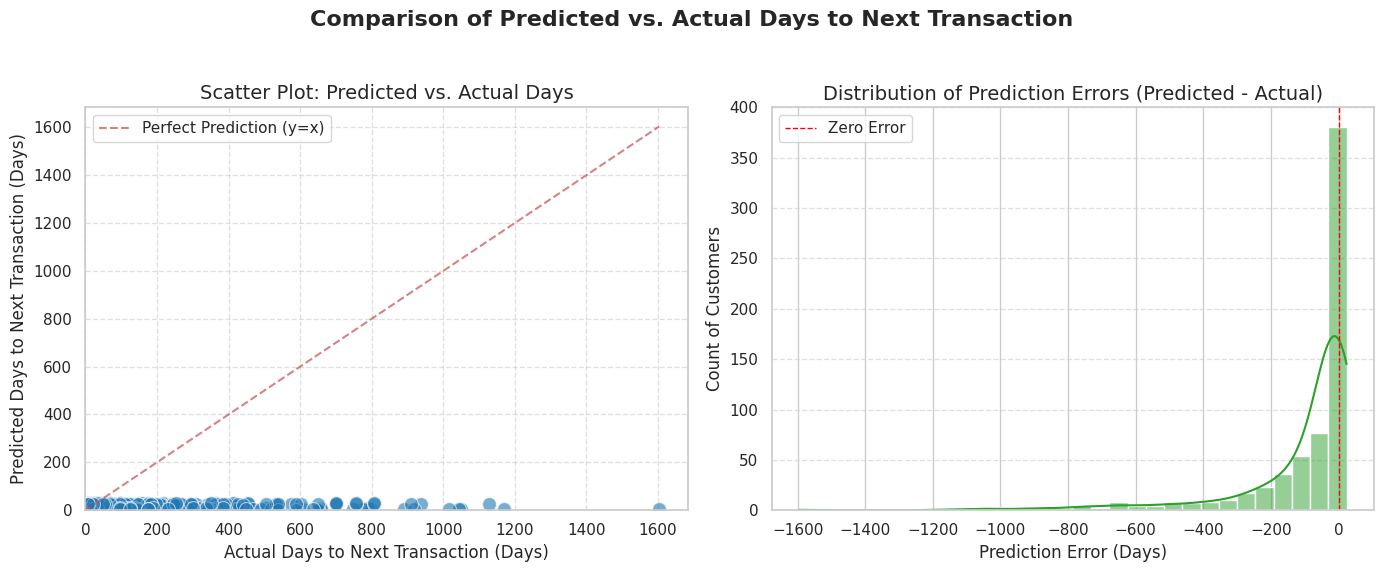


Model Performance Summary
Mean Absolute Error (MAE): 106.05 days


In [165]:
try:
    df_train = pd.read_csv('/content/train.csv', parse_dates=['Transaction Date'])
    df_test = pd.read_csv('/content/test.csv', parse_dates=['Transaction Date'])
    df_predictions = pd.read_csv('/content/predictions_lightgbm.csv')

    for df in [df_train, df_test, df_predictions]:
        if 'Customer ID' in df.columns:
            df.rename(columns={'Customer ID': 'Customer'}, inplace=True)
        if 'TransactionDate' in df.columns and 'Transaction Date' not in df.columns:
            df.rename(columns={'TransactionDate': 'Transaction Date'}, inplace=True)
    for df in [df_predictions]:
        if 'CustomerID' in df.columns:
            df.rename(columns={'CustomerID': 'Customer'}, inplace=True)
        if 'TransactionDate' in df.columns and 'Transaction Date' not in df.columns:
            df.rename(columns={'TransactionDate': 'Transaction Date'}, inplace=True)

except FileNotFoundError as e:
    print(f"Error: Could not find files: {e.filename}")

df_train_filtered = df_train[df_train['Product Category'] != 'Unknown'].copy()
df_test_filtered = df_test[df_test['Product Category'] != 'Unknown'].copy()

print(f"Predictions size before filtering: {len(df_predictions)}")
df_predictions_filtered = df_predictions[df_predictions['PredictedDaysToNextRounded'] != 0].copy()
print(f"Predictions size after filtering: {len(df_predictions_filtered)}")


df_LTT = df_train_filtered.groupby('Customer')['Transaction Date'].max().reset_index()
df_LTT.rename(columns={'Transaction Date': 'LastTransactionDate_Train'}, inplace=True)
df_NTT = df_test_filtered.groupby('Customer')['Transaction Date'].min().reset_index()
df_NTT.rename(columns={'Transaction Date': 'NextTransactionDate_Test'}, inplace=True)
df_actual_dates = pd.merge(df_LTT, df_NTT, on='Customer', how='inner')

df_actual_dates['ActualDaysToNext'] = (df_actual_dates['NextTransactionDate_Test'] - df_actual_dates['LastTransactionDate_Train']).dt.days
df_results = pd.merge(
    df_predictions_filtered,
    df_actual_dates[['Customer', 'ActualDaysToNext']],
    on='Customer',
    how='inner'
)

df_results['ActualPredictedDaysToNext'] = df_results['ActualDaysToNext'].round().astype(int)

df_results['PredictionError'] = df_results['PredictedDaysToNextRounded'] - df_results['ActualPredictedDaysToNext']
df_results['AbsoluteError'] = df_results['PredictionError'].abs()

print("\n--- Final Merged Results (Actual vs. Predicted) ---")
print(df_results[['Customer', 'PredictedDaysToNextRounded', 'ActualPredictedDaysToNext', 'AbsoluteError']].head())
print(f"\nSuccessfully evaluated {len(df_results)} customer predictions.")

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Comparison of Predicted vs. Actual Days to Next Transaction', fontsize=16, weight='bold')
sns.scatterplot(
    x='ActualPredictedDaysToNext',
    y='PredictedDaysToNextRounded',
    data=df_results,
    ax=axes[0],
    s=100,
    color='#1f77b4',
    alpha=0.6
)
max_val = df_results[['ActualPredictedDaysToNext', 'PredictedDaysToNextRounded']].max().max()
axes[0].plot([0, max_val], [0, max_val], 'r--', label='Perfect Prediction (y=x)', alpha=0.7)
axes[0].set_title('Scatter Plot: Predicted vs. Actual Days', fontsize=14)
axes[0].set_xlabel('Actual Days to Next Transaction (Days)', fontsize=12)
axes[0].set_ylabel('Predicted Days to Next Transaction (Days)', fontsize=12)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xlim(0, max_val * 1.05)
axes[0].set_ylim(0, max_val * 1.05)
sns.histplot(
    df_results['PredictionError'],
    bins=30,
    kde=True,
    ax=axes[1],
    color='#2ca02c'
)
axes[1].axvline(0, color='red', linestyle='--', linewidth=1, label='Zero Error')
axes[1].set_title('Distribution of Prediction Errors (Predicted - Actual)', fontsize=14)
axes[1].set_xlabel('Prediction Error (Days)', fontsize=12)
axes[1].set_ylabel('Count of Customers', fontsize=12)
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
MAE = df_results['AbsoluteError'].mean()
print(f"\nModel Performance Summary")
print(f"Mean Absolute Error (MAE): {MAE:.2f} days")
